In [1]:
# Imports

# %matplotlib widget

import ipywidgets as widgets
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift
import scipy.signal as sc
import scipy.io.wavfile as sc_wav
import csv 
import pandas as pd


compararConTabla()

In [2]:
def compararConTabla(pitch, pitchTable):
    encontrado = 0

    if pitch <= pitchTable[0]:
        pitchCorrecto = pitchTable[0]
        encontrado = 1

    if encontrado == 0:
        if pitch > pitchTable[len(pitchTable)-1]:
            pitchCorrecto = pitchTable[len(pitchTable)-1]
            encontrado = 1
        
    i = 1
    while encontrado == 0:
        if pitch > pitchTable[i] and pitch <= pitchTable[i+1]:
            pitchCorrecto = pitchTable[i+1]
            encontrado = 1
        i = i+1

    return pitchCorrecto

autoCorrelacion()

In [3]:
def auto_corr(x,fm):

    T = 1/fm 
    pmin = 50
    pmax = 400

    Tmin = 1/pmax
    Tmax = 1/pmin

    nmin = int(math.floor(Tmin/T))
    nmax = int(math.ceil(Tmax/T))

    x_cor = np.correlate(x,x,mode='full')
    x_cor = x_cor[len(x):len(x_cor)]

    i = np.argmax(x_cor[nmin:nmax])

    nF0 = i+nmin
    T0 = nF0*T

    F0 = 1/T0

    return F0

estimarF0()

In [4]:
def estimarF0(signal, F0Ref):

    tvent = 0.032
    tstep = 0.005804988662131519

    tamanioVent = int(tvent*rate)
    nstep = int(tstep*rate)

    cantidadVentanasRef = len(F0Ref)
    #usar cuadrada?
    vent = np.hanning(tamanioVent*2+1)
    vent = vent[np.arange(1,len(vent),2)]
    
    ini = tamanioVent//2
    F0Estimada = np.zeros(cantidadVentanasRef)

    for i in range(cantidadVentanasRef):
        if F0Ref[i]>0:
            F0Estimada[i] = auto_corr(signal[ini:ini + tamanioVent]*vent,rate)
        ini = ini + nstep

    treshold = 500
    for i in range(cantidadVentanasRef):
        if F0Estimada[i]>=treshold:
            F0Estimada[i] = F0Estimada[i-1]
    return F0Estimada

Main de estimación y búsqueda en la tabla

In [5]:
rate, signal = sc_wav.read('dataset_proyecto/vocadito_5.wav')

ref_aux = pd.read_csv('dataset_proyecto/vocadito_5_f0.csv', names = ['f0','t'])

ref = []
for col in ref_aux:
    col_ref = ref_aux[col].tolist()
    ref.append(col_ref)

F0Ref = ref[1]
tRef = ref[0]

tvent = 0.032
tstep = 0.005804988662131519
tamanioVent = int(tvent*rate)
nstep = int(tstep*rate)
cantidadVentanasRef = len(F0Ref)
vent = np.hamming(tamanioVent)

# Estimacion de F0 usando autocorrelacion

F0Estimada = estimarF0(signal, F0Ref)

pitchTable=[0,16.352,17.324,18.354,19.445,20.602,21.827,23.125,24.500,25.957,27.500,29.135,
            30.868,32.703,34.648,36.708,38.891,41.203,43.654,46.249,48.999,51.913,55.000,58.270,
            61.735,65.406,69.296,73.416,77.782,82.407,87.307,92.499,97.999,103.830,110.000,
            116.540,123.470,130.800,138.590,146.830,155.560,164.810,174.610,185.000,196.000,
            207.650,220.000,233.080,246.940,261.630,277.180,293.660,311.130,329.630,349.230,
            369.990,392.000,415.300,440.000,466.160,493.880,523.250,554.370,587.330,622.250,
            659.260,698.460,739.990,783.990,830.610,880.000,932.330,987.770,1046.500,1108.700,
            1174.700,1244.500,1318.500,1396.900,1480.000,1568.000,1661.200,1760.000,1864.700,
            1975.500,2093.000,2217.500,2349.300,2489.000,2637.000,2793.800,2960.000,3136.000,
            3322.400,3520.000,3729.300,3951.100,4186.000,4434.900,4698.600,4978.000,5274.000,
            5587.700,5919.900,6271.900,6644.900,7040.000,7458.600,7902.100,8372.000,8869.800,
            9397.300,9956.100,10548.100,11175.300,11839.800,12543.900,13289.800,14080.000,
            14917.200,15804.300,16744.000,17739.700,18794.500,19912.100,21096.200,22350.600]

F0RefSegunTabla = np.zeros(len(F0Ref))

for i in range(len(F0Ref)-1):
    F0RefSegunTabla[i] = compararConTabla(F0Ref[i], pitchTable)

F0EstimadaSegunTabla = np.zeros(len(F0Estimada))
for i in range(len(F0Estimada)-1):
    F0EstimadaSegunTabla[i] = compararConTabla(F0Estimada[i], pitchTable)

# Calculamos el ratio: factor de shift

ratio = F0EstimadaSegunTabla/F0Estimada
ratio[np.isnan(ratio)] = 1


<ipython-input-5-2ae7cd2cf843>:49: RuntimeWarning: invalid value encountered in true_divide
  ratio = F0EstimadaSegunTabla/F0Estimada


In [6]:
len(pitchTable)


127

Gráficos de estimación y búsqueda en la tabla

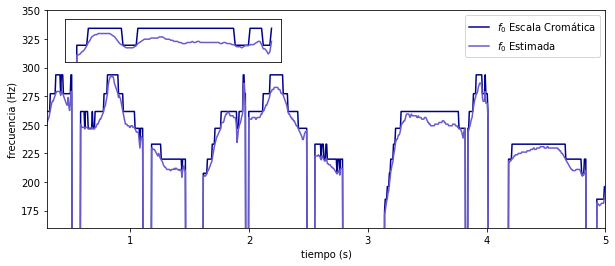

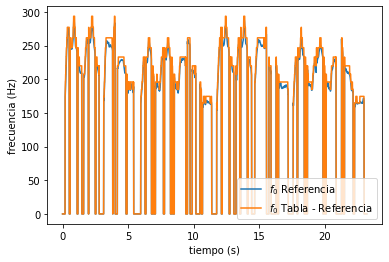

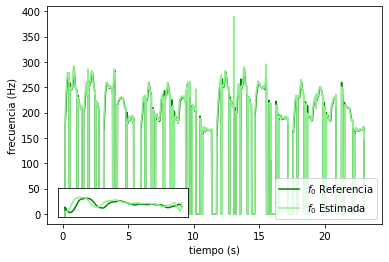

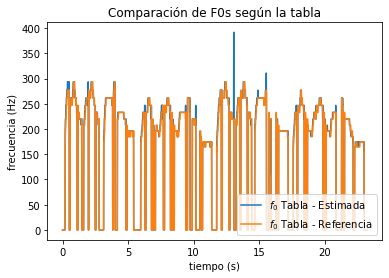

In [30]:
#GRAFICOS
plt.close('all')
#F0 estimada
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(tRef, F0EstimadaSegunTabla, label = '$f_0$ Escala Cromática', color = 'darkblue')
ax.plot(tRef, F0Estimada, label = '$f_0$ Estimada', color = 'slateblue')
ax.set_xlabel('tiempo (s)')
ax.set_ylabel('frecuencia (Hz)')
legend = ax.legend(loc='upper right')
ax.set_ylim(bottom = 160, top = 350)
ax.set_xlim(right= 5, left = 0.3)

ax_new = fig.add_axes([0.15, 0.70, 0.3, 0.15])
ax_new.plot(tRef[1840:1960], F0EstimadaSegunTabla[1840:1960], color = 'darkblue')
ax_new.plot(tRef[1840:1960], F0Estimada[1840:1960], color = 'slateblue')
ax_new.set_ylim(bottom = 155, top = 180)
ax_new.get_xaxis().set_visible(False)
ax_new.get_yaxis().set_visible(False)


plt.savefig('img_proyecto/F0_estimada_y_tabla.png')
plt.show()

#F0 referencia
fig, ax = plt.subplots()
ax.plot(tRef, F0Ref, label = '$f_0$ Referencia')
ax.plot(tRef, F0RefSegunTabla, label = '$f_0$ Tabla - Referencia')
ax.set_xlabel('tiempo (s)')
ax.set_ylabel('frecuencia (Hz)')
legend = ax.legend(loc='lower right')
plt.show()

#Comparación F0s
fig, ax = plt.subplots()
ax.plot(tRef, F0Ref, label = '$f_0$ Referencia', color = 'green')
ax.plot(tRef, F0Estimada, label = '$f_0$ Estimada', color = 'lightgreen')
ax.set_xlabel('tiempo (s)')
ax.set_ylabel('frecuencia (Hz)')
legend = ax.legend(loc='lower right')

ax_new = fig.add_axes([0.15, 0.15, 0.3, 0.10])
ax_new.plot(tRef[1840:1960], F0Ref[1840:1960], color = 'green')
ax_new.plot(tRef[1840:1960], F0Estimada[1840:1960], color = 'lightgreen')
ax_new.set_ylim(bottom = 155, top = 180)
ax_new.get_xaxis().set_visible(False)
ax_new.get_yaxis().set_visible(False)

plt.savefig('img_proyecto/comparacion_F0.png')
plt.show()

#Comparación F0s según la tabla
fig, ax = plt.subplots()
ax.plot(tRef, F0EstimadaSegunTabla, label = '$f_0$ Tabla - Estimada')
ax.plot(tRef, F0RefSegunTabla, label = '$f_0$ Tabla - Referencia')
ax.set_xlabel('tiempo (s)')
ax.set_ylabel('frecuencia (Hz)')
legend = ax.legend(loc='lower right')
plt.title('Comparación de F0s según la tabla')
plt.show()

In [8]:
def  crearFrames(x, salto, tamanioVent):
    
    nFrames = math.floor((len(x)-tamanioVent)/salto)

    # truncar la señal para tener numero entero de ventanas
    x = x[0:(nFrames*salto+tamanioVent)]

    vectorFrames = np.zeros((math.floor(len(x)/salto), tamanioVent))
    for i in range(nFrames):
        iTIni = (i)*salto
        iTFin = (i)*salto + tamanioVent
        
        vectorFrames[i,:] = x[iTIni: iTFin]


    return vectorFrames, nFrames

In [9]:
def fusionFrames(matrizFrames, salto):

    nFrames = len(matrizFrames)
    lenFrame = len(matrizFrames[0])

    iTime = 0
   
    vectorT = np.zeros(nFrames*salto - salto + lenFrame)

    # overlap-add
    for i in range(nFrames):
        vectorT[iTime:iTime + lenFrame] = vectorT[iTime:iTime + lenFrame] + matrizFrames[i,:]
        iTime = iTime + salto

    return vectorT

Pitchshift: esta funcion toma un vector de muestras en el dominio del tiempo y mueve (shiftea) el pitch por un factor de salto especifica, cada factor de salto es un semitono (halftone) y luego interpola poara obetener el pitch deseado sin afectar la duracion de la senal.

In [10]:
def pitchShift(x, tamanioVent, salto, ratio):
        
    # Ventana de hanning
    ventana = np.hanning(tamanioVent*2+1)
    ventana = ventana[np.arange(1,len(ventana),2)]
    x = np.concatenate((np.zeros((salto * 3)),x))
    
    ## Inicializacion
    # matriz de frames
    y, nFramesIn = crearFrames(x, salto, tamanioVent)
    nFramesOut = nFramesIn
    salida = np.zeros((nFramesOut, tamanioVent))
    
    #variables de fase
    phiAcum = 0
    phiPrevio = 0

    for index in range(nFramesIn):
        ## Analisis
        frameActual = y[index,:]
        frameActualVent = np.multiply(frameActual, ventana)
     
        # FFT
        FFT_frame = fft(frameActualVent)
        magFrame = abs(FFT_frame)
        phiFrame = np.angle(FFT_frame)

        ## Procesamiento

        # diferencia de fase
        deltaPhi = phiFrame - phiPrevio
        phiPrevio = phiFrame
        # Remover la diferencia de fase
        deltaPhiPrinc = deltaPhi - salto * 2 * math.pi * (np.arange(0,tamanioVent)) / tamanioVent
       #mapea de -pi / pi
        deltaPhiPrincMod = np.mod(deltaPhiPrinc + math.pi,2 * math.pi) - math.pi
        FreqReal = 2 * math.pi * np.arange(0,tamanioVent) / tamanioVent + deltaPhiPrincMod / salto

        
        alpha = ratio[index]
        saltoOut = round(alpha * salto)
        phiAcum = phiAcum + saltoOut * FreqReal
        
        ## Sintesis
        magSalida = magFrame
        frameOut = np.real(ifft(np.multiply(magSalida, np.exp(np.array([complex(0,i) for i in phiAcum])))))
        salida[index,:] = np.multiply(frameOut,np.transpose(ventana))

# Overlap add
    salida = fusionFrames(salida, saltoOut)

### interpolacion lineal para volver al tamaño inicial
    salida = np.interp(np.arange(0,(len(salida) - 1)+alpha,alpha),np.arange(0,len(salida)),salida)
   
    return salida
    

Main Shift vamos a usar el 1 el 5

In [11]:
a, b = sc_wav.read('dataset_proyecto/vocadito_5.wav')

signalCorregida = pitchShift(b, 1411, 256, ratio)

sc_wav.write('test_03.wav',44100, signalCorregida.astype(np.int16))

Estimar F0 del resultado

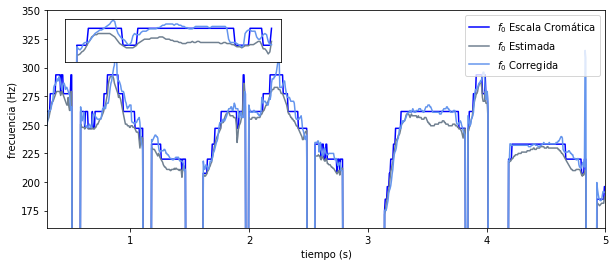

In [31]:
F0Corregida = estimarF0(signalCorregida, F0Ref)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(tRef, F0EstimadaSegunTabla, label = '$f_0$ Escala Cromática', color = 'b')
ax.plot(tRef, F0Estimada, label = '$f_0$ Estimada', color = 'slategray')
ax.plot(tRef, F0Corregida, label = '$f_0$ Corregida', color = 'cornflowerblue')
legend = ax.legend(loc='upper right')
ax.set_xlabel('tiempo (s)')
ax.set_ylabel('frecuencia (Hz)')
ax.set_ylim(bottom = 160, top = 350)
ax.set_xlim(right= 5, left = 0.3)

ax_new = fig.add_axes([0.15, 0.70, 0.3, 0.15])
ax_new.plot(tRef[1840:1960], F0EstimadaSegunTabla[1840:1960], color = 'b')
ax_new.plot(tRef[1840:1960], F0Estimada[1840:1960], color = 'slategray')
ax_new.plot(tRef[1840:1960], F0Corregida[1840:1960], color = 'cornflowerblue')
ax_new.set_ylim(bottom = 155, top = 180)
ax_new.get_xaxis().set_visible(False)
ax_new.get_yaxis().set_visible(False)

plt.savefig('img_proyecto/F0_corregida.png')

plt.show()

sc_wav.write('test_01.wav',rate,signalCorregida.astype(np.int16))
sc_wav.write('test_02.wav',rate,signal.astype(np.int16))
rate2, senal2 = sc_wav.read('test_01.wav')